# Cats and Dogs using DenseNet

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import OrderedDict

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

%matplotlib inline

# Helper functions and contants

In [2]:
DATA_DIR = "../datasets/kaggle_cats_and_dogs_subfolders"

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_NUM_CHANNELS = 3
NUM_CLASSES = 2
CLASSIFIER_INPUT = 1024
CLASSIFIER_HIDDEN = 500

BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 32
NUM_EPOCH = 1
LOG_EVERY = 25

CATSDOGS_MEANS = (0.485, 0.456, 0.406)
CATSDOGS_STDEVS = (0.229, 0.224, 0.225)

CLASSES = ["cat", "dog"]

In [3]:
def view_img_prob(img, prob, y, classes, num_channels=1, means=None, stdevs=None):
    """Show an image and associated probability distribution"""
    if prob is not None:
        fig, (ax1, ax2) = plt.subplots(figsize=(6, 9), ncols=2)
    else:
        fig, ax1 = plt.subplots(figsize=(6, 9), ncols=1)

    # Move the color dimension to the last column
    img = img.numpy()
    if num_channels == 3:
        img = img.transpose((1, 2, 0))

    # Denormalise the image
    if means is not None and stdevs is not None:
        img = stdevs * img + means
        img = np.clip(img, 0, 1)

    # Show the image
    if num_channels == 3:
        ax1.imshow(img)
    else:
        ax1.imshow(img.squeeze(), cmap="gray")

    ax1.axis('off')

    # Show the probability distribution if provided
    if prob is not None:
        ax2.barh(np.arange(len(classes)), prob)
        ax2.set_aspect(0.1)
        ax2.set_yticks(np.arange(len(classes)))
        ax2.set_yticklabels(classes)
        ax2.set_title('Probabilities')
        ax2.set_xlim(0, 1.0)
        print("Prediction: {} - Actual: {}".format(classes[prob.argmax()], classes[y.numpy()]))

    plt.tight_layout()

In [4]:
def predict_one(model, loader):
    """Use the model to predict the class of the first image returned by the dataloader"""
    # Grab the first batch
    load_iter = iter(loader)
    X, y = load_iter.next()

    # Predict
    with torch.no_grad():
        logsoftmax = model.forward(X)
        softmax = torch.exp(logsoftmax)
    
    softmax = softmax.numpy()

    # Show one image
    print("Softmax: {}".format(softmax[0]))
    view_img_prob(img=X[0], prob=softmax[0], y=y[0], classes=CLASSES,
              num_channels=IMG_NUM_CHANNELS, means=CATSDOGS_MEANS, stdevs=CATSDOGS_STDEVS)

# Create dataloaders

In [5]:
# Prepare image pre-processing
train_transforms = transforms.Compose([transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=CATSDOGS_MEANS,
                                                            std=CATSDOGS_STDEVS)
                           ])

test_transforms = transforms.Compose([transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
                            transforms.ToTensor(),
                                       transforms.Normalize(mean=CATSDOGS_MEANS,
                                                            std=CATSDOGS_STDEVS)
                           ])

# Pass transforms in here, then run the next cell to see how the transforms look
train = datasets.ImageFolder(DATA_DIR + '/train', transform=train_transforms)
test = datasets.ImageFolder(DATA_DIR + '/test', transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE_TEST)

# Show an image

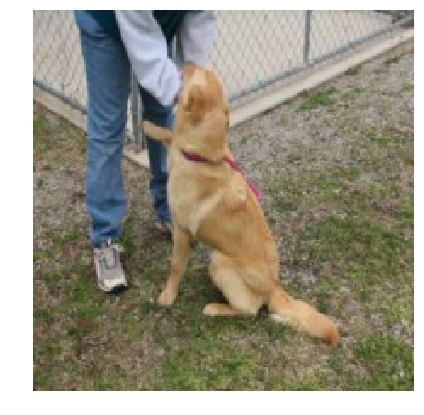

In [6]:
train_iter = iter(train_loader)
imgs, labels = train_iter.next()

view_img_prob(img=imgs[0], prob=None, y=labels[0], classes=CLASSES,
              num_channels=IMG_NUM_CHANNELS, means=CATSDOGS_MEANS, stdevs=CATSDOGS_STDEVS)

# Load DenseNet (pre-trained)
Model will be downloaded if not already available.

In [7]:
model = models.densenet121(pretrained=True)

/Users/geoff/anaconda3/envs/PYTORCH/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


# Show the trainable layers

In [8]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

# Replace the head, freeze parameters

In [9]:
# Freeze the pre-trained weights of all layers
for param in model.parameters():
    param.requires_grad = False

for layer in model.children():
    for param in layer.parameters():
        param.requires_grad = False

# Create the new head tailored to the cats and dogs data set
new_classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(CLASSIFIER_INPUT, CLASSIFIER_HIDDEN)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(CLASSIFIER_HIDDEN, NUM_CLASSES)),
    ('output', nn.LogSoftmax(dim=1))
]))

# Replace the existing classifier
model.classifier = new_classifier

# Train the model

In [10]:
def validate(model, device, val_loader):
    """Calculate loss and accuracy of the model on the entire validation set"""
    model.eval()
    loss = 0
    count = 0
    correct = 0

    with torch.no_grad():
        for X_val, y_val in val_loader:
            if device != "cpu":
                X_val, y_val = X_val.to(device), y_val.to(device)
                
            output = model.forward(X_val)
            loss += crit(output, y_val)
            pred = torch.exp(output)

            # Compare the actual labels to the argmax of the predictions
            count += len(X_val)
            correct += (y_val == pred.max(dim=-1)[1]).sum().item()

    model.train()

    return loss/len(val_loader), correct/count

In [11]:
def train_model(model, device, crit, opt, trn_loader, val_loader):
    """Train the model using the provided loss function, optimiser, training set
    data loader and validation set data loader"""
    start_time = time.time()
    model.zero_grad()

    # Move the model to the GPU if available
    if device != "cpu":
        model.to(device)

    for e in range(NUM_EPOCH):
        total_correct = 0
        total_count = 0
        total_loss = 0
        run_loss = 0
        batch = 0
        
        print("\nEpoch: {}/{}".format(e+1, NUM_EPOCH))
        print("=======================")

        for batch, (X, y) in enumerate(trn_loader, 0):
            model.train()
            opt.zero_grad()
            
            if device != "cpu":
                X, y = X.to(device), y.to(device)
            
            # Forward, backward and optimise
            output = model.forward(X)
            loss = crit(output, y)
            loss.backward()
            opt.step()
            
            # Convert to probabilities
            pred = torch.exp(output)
            
            # Keep track of metrics
            correct = (y == pred.max(dim=-1)[1]).sum().item()
            total_count += len(X)
            total_correct += correct
            total_loss += loss
            run_loss += loss
            
            # Apply to the validation set
            if batch % LOG_EVERY == (LOG_EVERY-1):
                # Print batch stats
                print("Batch {:04d}/{:04d} - Trn_loss: {:.4f}, Trn_acc: {:6.2f}% -".format(batch+1, len(trn_loader), run_loss/LOG_EVERY, 100*(correct/len(X)))),
                run_loss = 0
                
        # Print epoch stats
        val_loss, val_acc = validate(model, device, val_loader)
        print("\n                  Trn_loss: {:.4f}, Trn_acc: {:6.2f}% -".format(total_loss/len(trn_loader), 100*(total_correct/total_count)),
              "Val_loss: {:.4f}, Val_acc: {:6.2f}%".format(val_loss, 100*val_acc))

    # Move back to the CPU
    if device != "cpu":
        model.to("cpu")
        
    print("\nTraining complete, elapsed time: {:2f}min.".format((time.time() - start_time)/60))

In [ ]:
# Try using a GPU if one is present
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train using Adam
opt = optim.Adam(model.classifier.parameters(), lr=0.001)
crit = nn.NLLLoss()

# Don't attempt this on a CPU, it is extemely slow
train_model(model, device, crit, opt, train_loader, test_loader)


Epoch: 1/1


# Apply the trained model to the test set

In [ ]:
predict_one(model, test_loader)

# End of notebook